# Statistical Analysis

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import sqlite3

In [2]:
pd.set_option('precision', 3)

In [3]:
cursor = sqlite3.connect('../database/sstubs.db').cursor()
data = list(cursor.execute('SELECT * FROM sstubs_large'))
columns = cursor.execute(
    "SELECT name FROM PRAGMA_TABLE_INFO('sstubs_large')"
)
sstubs_df = pd.DataFrame(data=data, columns=[col for col, in columns])

In [4]:
sstubs_df.iloc[0]

parent              9d35cf00d8e3a28f8bacb48a9a16aeceb974325d
child               796f45d14550420d66e1ed28daefeb45874d195f
type                          CHANGE_CALLER_IN_FUNCTION_CALL
project                                            ACRA.acra
file       acra-limiter/src/main/java/org/acra/config/Lim...
line                                                      83
before                               stacktrace.indexOf(':')
after                                 firstLine.indexOf(':')
Name: 0, dtype: object

In [5]:
sstubs_df = sstubs_df.merge(
    right=pd.read_csv('../database/sstubs_large_distances.csv'),
    left_on='child',
    right_on='commit'
)

In [6]:
bugTypeMap = {
    'CHANGE_MODIFIER': 'Change Modifier',
    'CHANGE_NUMERAL': 'Change Numeric Literal',
    'DIFFERENT_METHOD_SAME_ARGS': 'Wrong Function Name',
    'CHANGE_IDENTIFIER': 'Change Identifier Used',

    'CHANGE_CALLER_IN_FUNCTION_CALL': 'Same Function Change Caller',
    'LESS_SPECIFIC_IF': 'Less Specific If',
    'MORE_SPECIFIC_IF': 'More Specific If',
    'CHANGE_OPERAND': 'Change Operand',

    'SWAP_ARGUMENTS': 'Same Function Swap Args',
    'OVERLOAD_METHOD_MORE_ARGS': 'Same Function More Args',
    'OVERLOAD_METHOD_DELETED_ARGS': 'Same Function Less Args',
    'CHANGE_OPERATOR': 'Change Binary Operator',

    'CHANGE_UNARY_OPERATOR': 'Change Unary Operator',
    'SWAP_BOOLEAN_LITERAL': 'Change Boolean Literal',
    'ADD_THROWS_EXCEPTION': 'Missing Throws Exception',
    'DELETE_THROWS_EXCEPTION': 'Delete Throws Exception',
}

sstubs_df['type'] = sstubs_df['type'].map(bugTypeMap)

In [7]:
sstubs_df.iloc[0]

parent               9d35cf00d8e3a28f8bacb48a9a16aeceb974325d
child                796f45d14550420d66e1ed28daefeb45874d195f
type                              Same Function Change Caller
project                                             ACRA.acra
file        acra-limiter/src/main/java/org/acra/config/Lim...
line                                                       83
before                                stacktrace.indexOf(':')
after                                  firstLine.indexOf(':')
commit               796f45d14550420d66e1ed28daefeb45874d195f
distance                                                    1
Name: 0, dtype: object

In [8]:
stat_df = sstubs_df[['parent', 'child', 'type', 'distance']]
fix_df = stat_df[stat_df.distance > 1]
stat_df.iloc[0]

parent      9d35cf00d8e3a28f8bacb48a9a16aeceb974325d
child       796f45d14550420d66e1ed28daefeb45874d195f
type                     Same Function Change Caller
distance                                           1
Name: 0, dtype: object

In [9]:
print(f'Total entries: {len(stat_df):,}')
print(f'Entries for refix paths: {len(fix_df):,}')
print(f'Unique commits in refix paths: {len(fix_df.child.unique()):,}')

Total entries: 63,923
Entries for refix paths: 2,881
Unique commits in refix paths: 591


## General Exploration

In [10]:
stat_df.groupby('distance').agg('size')

distance
1     61042
2      2408
3       315
4        86
5        22
6        20
7        15
8         3
9         5
10        2
11        3
12        2
dtype: int64

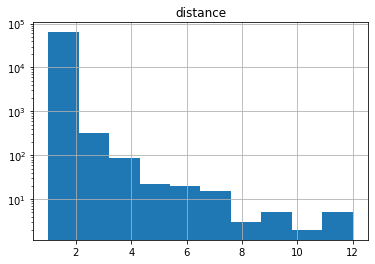

In [11]:
ax = stat_df.hist(log=True)

array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

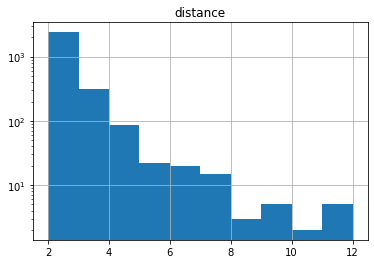

In [12]:
fix_df.hist(log=True)

In [13]:
stat_df.describe(percentiles=[.90, .99, .999])

,distance
count,63923.000
mean,1.058
std,0.326
min,1.000
50%,1.000
90%,1.000
99%,2.000
99.9%,5.000
max,12.000


> The min value for `distance` is `1`.
> This is because `distance` is `0` for the commits without parents.
> There is no dedicated row for such commits in `sstubs_large`.

In [14]:
fix_df.describe(percentiles=[.825, .90, .99, .999])

,distance
count,2881.000
mean,2.286
std,0.882
min,2.000
50%,2.000
82.5%,2.000
90%,3.000
99%,7.000
99.9%,11.000
max,12.000


In [15]:
print(f'SStuBs Skewness: {stat_df.distance.skew()}')
print(f'Fix Skewness: {fix_df.distance.skew()}')

SStuBs Skewness: 10.805853473940637
Fix Skewness: 5.2347588033480426


In [16]:
print(f'SStuBs Kurtosis: {stat_df.distance.kurt()}')
print(f'Fix Kurtosis: {fix_df.distance.kurt()}')

SStuBs Kurtosis: 199.9706992380031
Fix Kurtosis: 36.5528411726385


## Bug Type Wise Exploration


### Description

In [17]:
describe_df = fix_df.groupby(by='type').distance\
    .describe(percentiles=[.75, .85, .95])\
    .sort_values('count', ascending=False)
describe_df

,count,mean,std,min,50%,75%,85%,95%,max
type,,,,,,,,,
Change Identifier Used,1086.0,2.257,0.762,2.0,2.0,2.0,2.0,4.00,8.0
Wrong Function Name,849.0,2.283,0.801,2.0,2.0,2.0,3.0,4.00,8.0
Change Numeric Literal,295.0,2.454,0.538,2.0,2.0,3.0,3.0,3.00,4.0
Change Modifier,156.0,2.955,2.345,2.0,2.0,2.0,3.0,9.00,12.0
Same Function Less Args,114.0,2.026,0.161,2.0,2.0,2.0,2.0,2.00,3.0
Same Function More Args,92.0,2.043,0.205,2.0,2.0,2.0,2.0,2.00,3.0
Change Binary Operator,83.0,2.024,0.154,2.0,2.0,2.0,2.0,2.00,3.0
Change Boolean Literal,50.0,2.020,0.141,2.0,2.0,2.0,2.0,2.00,3.0
More Specific If,39.0,2.026,0.160,2.0,2.0,2.0,2.0,2.00,3.0


### Histogram

In [18]:
def plot_hist(sharey = True):
    axes = fix_df.hist(
        column='distance',
        by='type',
        bins=[i+2 for i in range(10)],
        sharey=sharey,
        layout=(-1, 2),
        figsize=(10, 75),
        color='#0092A6'
    )

    vip_types = [
        'Change Identifier Used',
        'Wrong Function Name',
        'Change Numeric Literal',
        'Change Modifier',
    ]

    vip_clr, ip_clr, clr = 'magenta', 'lime', 'skyblue'

    for row_ax in axes:
        for ax in row_ax:
            _clr = clr
            if ax.get_title() in vip_types:
                _clr = vip_clr
            ax.title.set_color(_clr)
            ax.tick_params(axis='x', colors='#0092A6')
            ax.tick_params(axis='y', colors='#0092A6')

    return axes

#### Same Height
> In the following plots, all histograms will have the same height.
> This will help to compare how refixes are distributed among all bug-types.

array([[<AxesSubplot:title={'center':'Change Binary Operator'}>,
        <AxesSubplot:title={'center':'Change Boolean Literal'}>],
       [<AxesSubplot:title={'center':'Change Identifier Used'}>,
        <AxesSubplot:title={'center':'Change Modifier'}>],
       [<AxesSubplot:title={'center':'Change Numeric Literal'}>,
        <AxesSubplot:title={'center':'Change Operand'}>],
       [<AxesSubplot:title={'center':'Change Unary Operator'}>,
        <AxesSubplot:title={'center':'Delete Throws Exception'}>],
       [<AxesSubplot:title={'center':'Less Specific If'}>,
        <AxesSubplot:title={'center':'Missing Throws Exception'}>],
       [<AxesSubplot:title={'center':'More Specific If'}>,
        <AxesSubplot:title={'center':'Same Function Change Caller'}>],
       [<AxesSubplot:title={'center':'Same Function Less Args'}>,
        <AxesSubplot:title={'center':'Same Function More Args'}>],
       [<AxesSubplot:title={'center':'Same Function Swap Args'}>,
        <AxesSubplot:title={'center

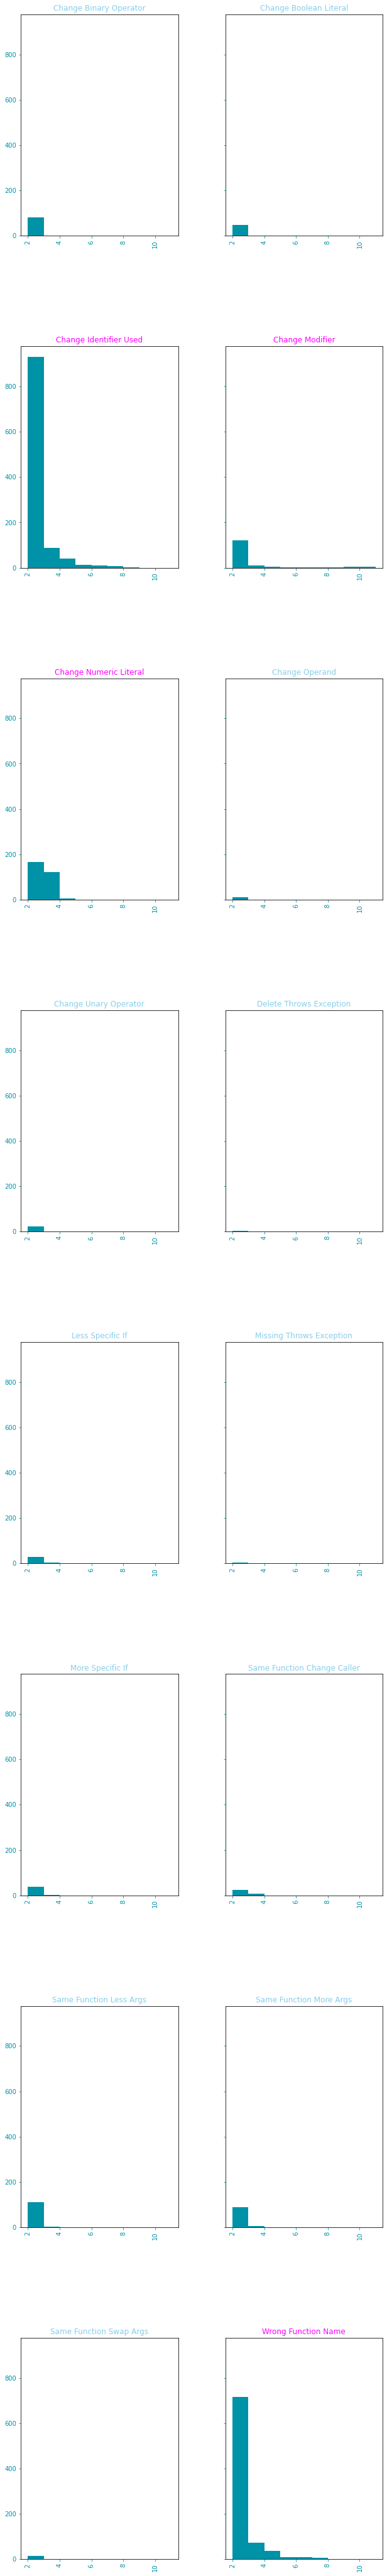

In [19]:
plot_hist(sharey=True)

#### Variable Height
> In the following plots, all histograms will have a height based on the
> amount of data inside the group.
> This will help to analyze how different refix lengths are distributed
> inside a single bug-type

array([[<AxesSubplot:title={'center':'Change Binary Operator'}>,
        <AxesSubplot:title={'center':'Change Boolean Literal'}>],
       [<AxesSubplot:title={'center':'Change Identifier Used'}>,
        <AxesSubplot:title={'center':'Change Modifier'}>],
       [<AxesSubplot:title={'center':'Change Numeric Literal'}>,
        <AxesSubplot:title={'center':'Change Operand'}>],
       [<AxesSubplot:title={'center':'Change Unary Operator'}>,
        <AxesSubplot:title={'center':'Delete Throws Exception'}>],
       [<AxesSubplot:title={'center':'Less Specific If'}>,
        <AxesSubplot:title={'center':'Missing Throws Exception'}>],
       [<AxesSubplot:title={'center':'More Specific If'}>,
        <AxesSubplot:title={'center':'Same Function Change Caller'}>],
       [<AxesSubplot:title={'center':'Same Function Less Args'}>,
        <AxesSubplot:title={'center':'Same Function More Args'}>],
       [<AxesSubplot:title={'center':'Same Function Swap Args'}>,
        <AxesSubplot:title={'center

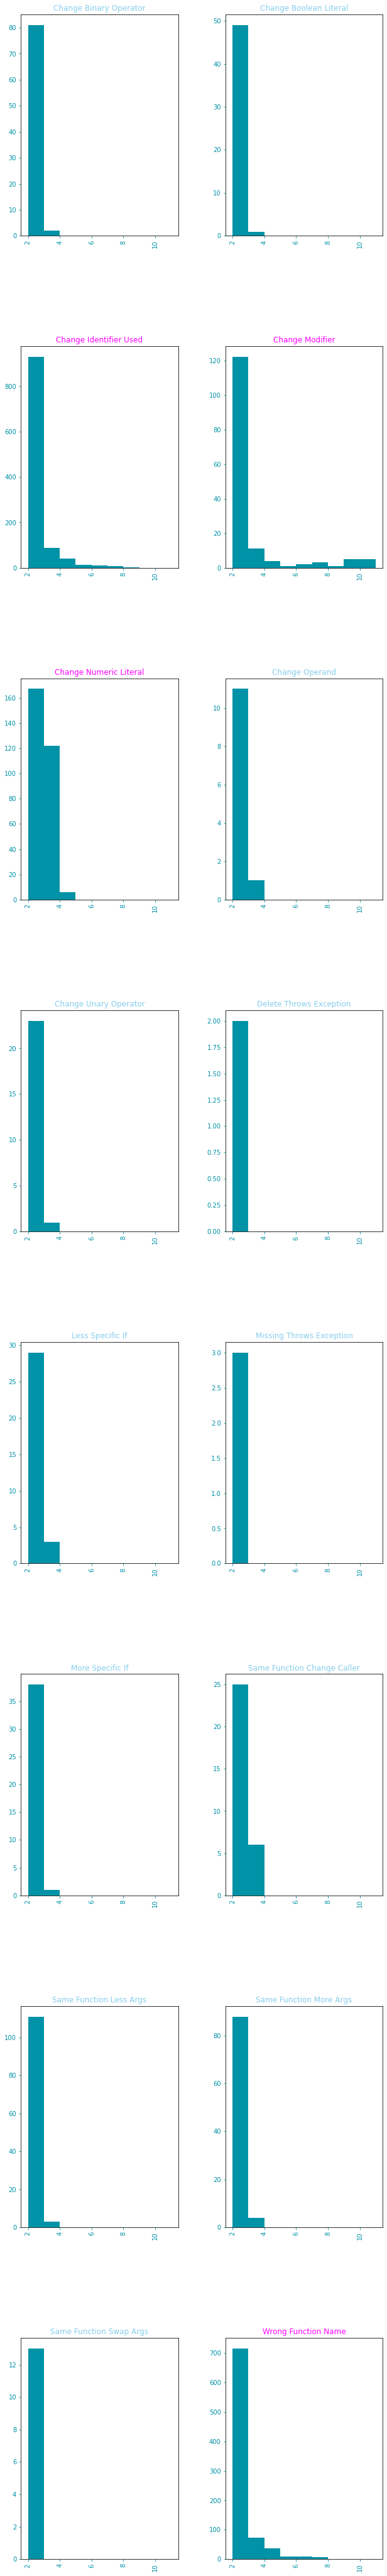

In [20]:
plot_hist(sharey=False)

### Central Tendency

In [21]:
central_tendency_df = fix_df.groupby('type').distance\
    .agg(['mean', stats.hmean, stats.gmean])\
    .sort_values('mean', ascending=False)
central_tendency_df

,mean,hmean,gmean
type,,,
Change Modifier,2.955,2.296,2.502
Change Numeric Literal,2.454,2.347,2.399
Wrong Function Name,2.283,2.147,2.199
Change Identifier Used,2.257,2.133,2.181
Same Function Change Caller,2.194,2.138,2.163
Less Specific If,2.094,2.065,2.077
Change Operand,2.083,2.057,2.069
Same Function More Args,2.043,2.029,2.036
Change Unary Operator,2.042,2.028,2.034


### Variance

In [22]:
variance_df = fix_df.groupby('type').distance\
    .agg(['var', 'std', 'min', 'max'])\
    .sort_values('var', ascending=False)
variance_df

,var,std,min,max
type,,,,
Change Modifier,5.501,2.345,2,12
Wrong Function Name,0.642,0.801,2,8
Change Identifier Used,0.580,0.762,2,8
Change Numeric Literal,0.290,0.538,2,4
Same Function Change Caller,0.161,0.402,2,3
Less Specific If,0.088,0.296,2,3
Change Operand,0.083,0.289,2,3
Same Function More Args,0.042,0.205,2,3
Change Unary Operator,0.042,0.204,2,3


### Symmetry

In [23]:
symmetry_df = fix_df.groupby('type').distance\
    .agg(['count', 'skew', pd.Series.kurt])\
    .sort_values('skew', ascending=False)
symmetry_df

,count,skew,kurt
type,,,
Change Boolean Literal,50,7.071,50.000
Change Binary Operator,83,6.322,38.900
More Specific If,39,6.245,39.000
Same Function Less Args,114,5.998,34.577
Change Unary Operator,24,4.899,24.000
Same Function More Args,92,4.552,19.134
Change Identifier Used,1086,3.833,16.735
Wrong Function Name,849,3.682,15.434
Change Operand,12,3.464,12.000
